# Beispiel: Frequenzlauf für den bimorphen Kragbalken

## Geometrie
besteht aus 2 Teilen (Schichten) aus dem gleichen Material, 3 Elektroden. Alle Ebenen haben Normalvektor in pos. Koordinatenrichtung, das wird bei Differenzen/Schnittmengen berücksichtigt

In [13]:
import netgen.gui
%gui tk

from netgen.csg import *
from ngsolve import *


## there may be conflicting versions for netgen-gui and matplotlib
## to import matplotlib, but without tkinter backend, uncomment two lines
# import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

import numpy as np

In [14]:
#### Geometry
scale = 1e3  # --> computation in mm
h = 0.002*scale
b = 0.01*scale
l = 0.1*scale

## Plane means halfspace in CSG: 
## Plane(p, n) -- plane in Point p, outer normal vector n
## bc -- set boundary condition number
p_x0 =  Plane(Pnt(0,0,0),  Vec(-1,0,0)).bc("fix")
p_x1 = Plane(Pnt(l,0,0),  Vec(1,0,0)) .bc("tip")
p_z1 =   Plane(Pnt(0,0,h),  Vec(0,0,1)) .bc("free_el1")
p_z0 =  Plane(Pnt(0,0,-h), Vec(0,0,-1)).bc("free_el2")
p_zm = Plane(Pnt(0,0,0),  Vec(0,0,1)) .bc("free_el0")
p_y1 =  Plane(Pnt(0,b/2,0),  Vec(0,1,0)) .bc("free")
p_y0 = Plane(Pnt(0,-b/2,0),  Vec(0,-1,0)).bc("free")

## generate geometry from halfspaces
## consists of two hexaedra made from 6 planes
## * ... intersection 
## - ... difference
## + ... union
geometry = CSGeometry()
matnr_1 = geometry.Add( ((p_x0 * p_x1 * p_z1 * p_y1 * p_y0) - p_zm).mat("bot_mat"))
matnr_2 = geometry.Add( (p_x0 * p_x1* p_z0 * p_zm * p_y1 * p_y0).mat("top_mat"))
## define surfaces that are parallel, then prismatic elements are generated between these planes
geometry.CloseSurfaces(p_zm, p_z0, slices=[0.5])
geometry.CloseSurfaces(p_zm, p_z1, slices = [0.5])
geometry.Draw()
netgenmesh = geometry.GenerateMesh(maxh=0.005*scale)
ZRefinement(netgenmesh, geometry)
mesh = Mesh(netgenmesh)
Draw(mesh)


 Calc Triangle Approximation
 Object 0 has 1860 triangles
 Object 1 has 1876 triangles
 Start Findpoints
 Analyze spec points
 Find edges
 Start Findpoints
 Analyze spec points
 Find edges
 Start Findpoints
 Analyze spec points
 Find edges
 Surface 1 / 11
 Surface 2 / 11
 Surface 3 / 11
 Optimize Surface
 Surface 4 / 11
 Surface 5 / 11
 Surface 8 / 11
 Surface 9 / 11
 Surface 10 / 11
 Surface 11 / 11
 Surface 6
 Surface 7
 Remove Illegal Elements
 Volume Optimization


In [15]:
## useful - get strain vector representation

def strainvec(u):
    g = grad(u)
    return CoefficientFunction((g[0], g[4], g[8], g[5]+g[7], g[2]+g[6], g[1]+g[3]))

## material parameters
epsilon0 = 8.8541878e-12

CE_matrix = 1e9/scale/scale*np.array([[121, 75.9, 75.4, 0, 0, 0],
                          [75.9, 121, 75.4, 0, 0, 0],
                          [75.4, 75.4, 111, 0, 0, 0],
                          [0, 0, 0, 21.1, 0, 0],
                          [0, 0, 0, 0, 21.1, 0],
                          [0, 0, 0, 0, 0, 22.6]])

e15 = 12.3
e31 = -5.4
e33 = 15.8
e_matrix = 1/scale*np.array([[0, 0, 0, 0, e15, 0],
                     [0, 0, 0, e15, 0, 0],
                     [e31, e31, e33, 0, 0,0]])

epseps_matrix = epsilon0*np.array([[916, 0, 0],[0,916,0],[0,0,830]])


## material parameters as ngsolve coefficient functions

CEtensor = CoefficientFunction(tuple(CE_matrix.reshape(1, -1)[0]), dims=(6,6))
etensor = CoefficientFunction(tuple(e_matrix.reshape(1, -1)[0]), dims=(3,6))
epstensor = CoefficientFunction(tuple(epseps_matrix.reshape(1, -1)[0]), dims=(3,3))

density = 7750/scale**4

## FE

In [16]:
## the finite element solution space

## for the displacements - vector-valued H1 elements, dirichlet-zero condition on "fix" bd
V_u = VectorH1(mesh, order=3, dirichlet="fix")

## for the electric potential - H1 elements, dirichlet-zero condition on electrodes
V_phi = H1(mesh, order=3, dirichlet=".*el.")

## together 
V = V_u * V_phi
q = GridFunction(V)

u = q.components[0]
phi = q.components[1]

strain = strainvec(u)
elfield = -grad(phi)

stress = CEtensor*strain - etensor.trans*elfield
diel = etensor*strain + epstensor*elfield

Draw(u, mesh, "u")
Draw(phi, mesh, "phi")
Draw(BoundaryFromVolumeCF(elfield), mesh, "E")
Draw(BoundaryFromVolumeCF(strain), mesh, "strain")
Draw(BoundaryFromVolumeCF(diel), mesh, "D")
Draw(BoundaryFromVolumeCF(stress), mesh, "stress")

Setzen von phi0

In [17]:
## potential Phi = Phi_0 + Phi_tilde (homogenzation of boundary conditions)
## set finite element function U_0 boundary values
phi_0 = GridFunction(V_phi)

phi_bdvalues = mesh.BoundaryCF({"free_el1": 75, "free_el2": 75, "free_el0": 0}, default=0)
# phi_bdvalues = mesh.BoundaryCF({"free_el1": 0, "free_el2": 0, "free_el0": 0}, default=0)
phi_0.Set(phi_bdvalues, definedon=mesh.Boundaries(".*el."))

t = 1e-2

Steifigkeits- und Massenmatrix

Als Anregung wird entweder die Spannung zeitharmonisch angegeben (phi_0 verwenden) oder eine zeitharmonische Endlast aufgebracht (t verwenden)



In [18]:
## definition of the bilinear form 
## int sigma : deps - D dE dx
U, PHITILDE = V.TrialFunction()
DELTAU, DELTAPHI = V.TestFunction()

STRAIN = strainvec(U)
DELTASTRAIN = strainvec(DELTAU)

a = BilinearForm(V)
a += SymbolicBFI( InnerProduct(CEtensor*STRAIN + etensor.trans*(grad(PHITILDE)+grad(phi_0)), DELTASTRAIN) )
a += SymbolicBFI( InnerProduct(etensor*STRAIN - epstensor*(grad(PHITILDE)+grad(phi_0)), grad(DELTAPHI)) )
# a += SymbolicBFI(t*DELTAU[1], definedon=mesh.Boundaries("tip"))

## definition mass matrix
## int rho u deltau dx

m = BilinearForm(V)
m += SymbolicBFI(density*InnerProduct(U, DELTAU))




In [19]:
a.AssembleLinearization(q.vec)
m.AssembleLinearization(q.vec)

rhs = q.vec.CreateVector()
a.Apply(q.vec, rhs)
rhs.data *= -1

## dummy matrix for storing - omega^2 M + K
helpmatrix = a.mat.CreateMatrix()

Für verschiedene Frequenzen omega wird nur gelöst, und für jedes omega die Durchbiegung ausgewertet, in die Ausgabedatei geschrieben.

In [22]:
omegalist = []
displist = []

outputfile = open("frequenzlauf_3d_.txt", "w")
for omega in range(0,10000,100):
    helpmatrix.AsVector().data = - omega**2*m.mat.AsVector() + a.mat.AsVector()
    inv = helpmatrix.Inverse(V.FreeDofs(), inverse="pardiso") # "umfpack"

    q.vec.data = inv * rhs
    
    disp_avg = 1/b/(2*h)*Integrate(u[2], mesh, definedon=mesh.Boundaries("tip"))
    
    omegalist += [omega]
    displist += [abs(disp_avg)]
    print(f"{omegalist[-1]}\t{displist[-1]}", file=outputfile)
    outputfile.flush()
outputfile.close()

    

/var/folders/7k/qv8q_x7j7zb1j_js1j824fm00000gq/T/ipykernel_1003/4217496523.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


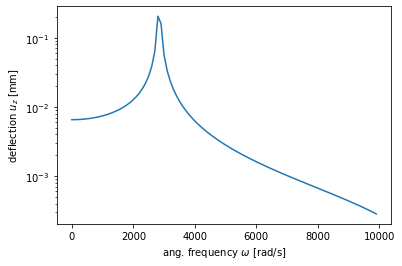

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy()
ax.set_xlabel(r"ang. frequency $\omega$ [rad/s]")
ax.set_ylabel(r"deflection $u_z$ [mm]")

ax.plot(omegalist, displist)
#fig.savefig('bimbeam_freq.png')
fig.show()


Evaluate/plot for given frequency

In [12]:
omega = 1200
omega = 7300
helpmatrix.AsVector().data = - omega**2*m.mat.AsVector() + a.mat.AsVector()
inv = helpmatrix.Inverse(V.FreeDofs(), inverse="pardiso")

q.vec.data = inv * rhs
